# This code is to check for Urban heat island effect over Brisbane

In [2]:
import osmnx as ox
import geopandas as gpd 
import intake
from easygems import healpix as egh
import healpy as hp
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from cartopy.io import shapereader as shpreader
from cartopy.feature import ShapelyFeature
import xarray as xr
from pathlib import Path
from rasterio import features
import os

import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cf
states_provinces = cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none')


In [3]:
import xarray as xr
from pathlib import Path


In [43]:
plot_path='/home/561/dc5055/WCRP_HK25/'

# Gadi location:
* Only zoom 1 and 2 on scratch
* https://github.com/21centuryweather/hackathon-2025-australia-node/blob/main/notebooks/regrid_to_era5.ipynb
* Changing path to scratch

In [4]:
zoom_lev = '10'
# file = '/scratch/nf33/Healpix_data/UM/data.healpix.PT3H.z' + zoom + '.zarr'
data_2d_z2 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z" + zoom_lev +".zarr" #PT1H is hourly data
ds_2 = xr.open_zarr(data_2d_z2)
# ds2d = xr.open_zarr(data_2d_z2)

In [75]:
ds_2

<xarray.Dataset> Size: 13TB
Dimensions:  (cell: 12582912, time: 10489)
Coordinates:
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
Data variables: (12/26)
    clivi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clt      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clwvi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hflsd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hfssd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    huss     (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ...       ...
    rsutcs   (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    sftlf    (cell) float64 101MB dask.array<chunksize=(98304,), meta=np.ndarray>
    tas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ts       (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    uas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    vas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>

### Function for lat-lon
* https://github.com/21centuryweather/hackathon-2025-australia-node/blob/main/notebooks/regrid_to_era5.ipynb

In [5]:
def get_nn_lon_lat_index(nside, lons, lats):
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

In [9]:
int(zoom_lev)

10

### Specifying lon/lat range around BNE

In [6]:
lon_range_bne=np.linspace(145, 160, 300)
lat_range_bne=np.linspace(-35, -20, 300)

idx = get_nn_lon_lat_index(
    2**int(zoom_lev),
    lon_range_bne, 
    lat_range_bne
)

ts_3D = ds_2["ts"].where(ds_2['sftlf']>0).isel(cell=idx)  # this is data conversion

/scratch/nf33/public/miniconda/envs/digital_earths_env/lib/python3.12/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


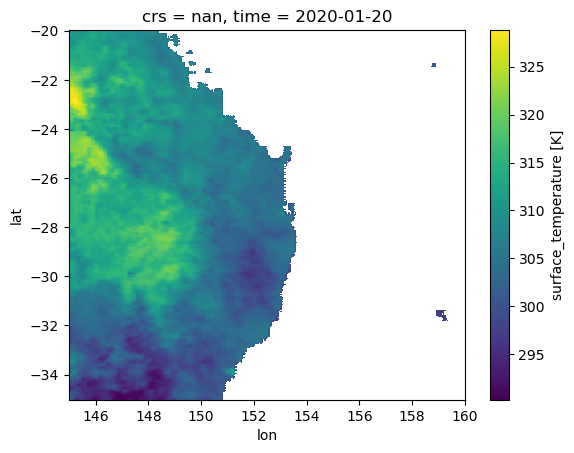

In [7]:
# ts_3D[0].plot()

# Using osmnx for city analysis Brisbane

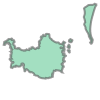

In [8]:
cities = [
    "Brisbane",
    "Sydney",
    "Melbourne",
]
gdf = ox.geocode_to_gdf(cities[0])
gdf.geometry[0]

In [9]:
# gdf = ox.geocode_to_gdf('W352332709', by_osmid=True)
polygon = gdf.iloc[0]['geometry']
# polygon.boundary

In [75]:
print(gdf['geometry'].geom_type)

0    MultiPolygon
dtype: object


In [10]:
gdf_proj = gdf.to_crs(epsg=3857) 
geom = gdf_proj.geometry[0]
# geom

### Getting just BRISBANE MAIN CITY

In [11]:
from shapely.geometry import MultiPolygon, Polygon, Point

In [12]:
# Extract the geometry
geom = gdf.loc[0, 'geometry']

# If it's a MultiPolygon, get the largest one by area
if isinstance(geom, MultiPolygon):
    largest_poly = max(geom.geoms, key=lambda a: a.area)
elif isinstance(geom, Polygon):
    largest_poly = geom
else:
    raise TypeError("Geometry is not a Polygon or MultiPolygon")

# Result: largest polygon
# print(largest_poly)

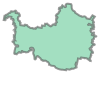

In [13]:
largest_poly

In [16]:
gdf_bne = gpd.GeoDataFrame(index=[0], geometry=[largest_poly], crs=gdf.crs)

In [17]:
gdf_bne.geom_type

0    Polygon
dtype: object

In [18]:
gdf_bne.area

/jobfs/140911421.gadi-pbs/ipykernel_2217023/1826141651.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_bne.area


0    0.108854
dtype: float64

In [20]:
gdf_bne_proj = gdf_bne.to_crs(epsg=3857) 
geom_bne = gdf_bne_proj.geometry[0]
geom_bne.area/1e6

1520.478339486387

### Getting area of BNE

In [21]:
if geom_bne.geom_type == "Polygon":
    area_km2 = geom_bne.area / 1e6
    print(f"Area: {area_km2:.2f} km²")
if geom_bne.geom_type == "MultiPolygon":
    area_km2 = geom_bne.area / 1e6
    print(f"Area: {area_km2:.2f} km²")
elif geom_bne.geom_type == "LineString":
    length_km = geom_bne.length / 1e3
    print(f"Length: {length_km:.2f} km")

Area: 1520.48 km²


## Plotting data with urban BNE boundary

In [22]:
bne_geometry = gdf_bne.geometry.iloc[0]  # Extract the first geometry

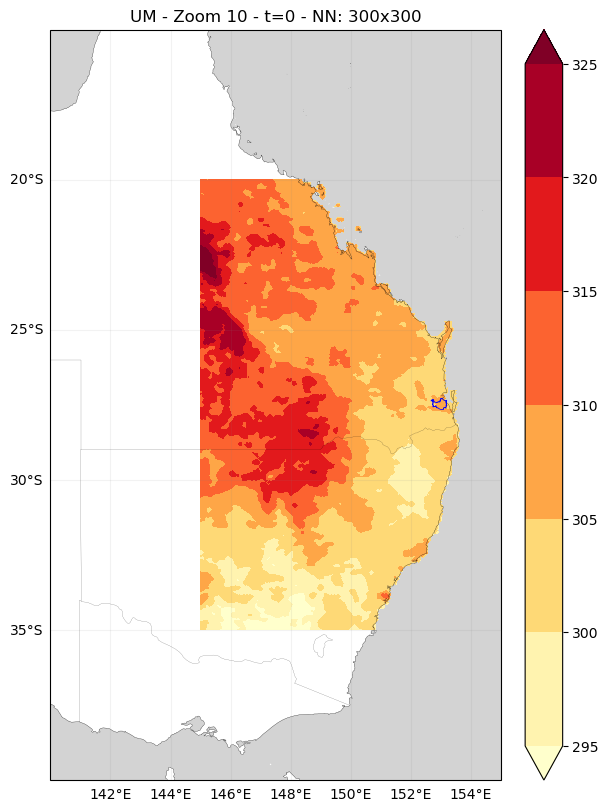

In [25]:
fig=plt.figure(figsize=(6,8), facecolor='w',constrained_layout=True)

ax=plt.subplot(111, projection=ccrs.PlateCarree())

ax.coastlines(linewidth=0.2)
ax.add_feature(states_provinces, linewidth=0.1)
ax.add_feature(cf.OCEAN, facecolor='lightgray')
bne_boundary = ShapelyFeature([bne_geometry], ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linestyle='-', linewidth=0.5)
ax.add_feature(bne_boundary)
ax.set_extent([140,155, -40, -15], ccrs.PlateCarree())
gl=ax.gridlines(alpha=0.1, draw_labels=True, color='gray')
gl.top_labels = False
gl.right_labels = False

cm=ax.contourf(ts_3D.lon, ts_3D.lat, ts_3D[0], cmap='YlOrRd', levels=None,
                     extend='both', transform=ccrs.PlateCarree())
plt.title(f'UM - Zoom {zoom_lev} - t=0 - NN: 300x300')
plt.colorbar(cm)
plt.show()

## Using 1pm local time as max temperature time
* BNE time is 10 hours ahead
* Taking 3pm UTC - 15 months of data
* Could account for daylight savings
* Could google sunrise and sunset times - and take avg of max and min during day and night

In [34]:
ts_3D_1pm=ts_3D[3:][::24]

# Getting the mask of BNE and buffer area around it 

### Getting centroid of BNE and distance to exteriors from the largest_poly defined above

In [26]:
centroid_bne=largest_poly.centroid

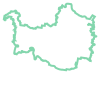

In [27]:
largest_poly.exterior#.x

In [28]:
from geopy.distance import geodesic

In [29]:
# Compute max radius from centroid to boundary
boundary_coords = np.array(largest_poly.exterior.coords)
distances_m = [
    geodesic((centroid_bne.y, centroid_bne.x), (lat, lon)).meters
    for lon, lat in boundary_coords  # coords = (lon, lat)
]
radius_m = max(distances_m)
radius_km = radius_m / 1000
center_lat, center_lon = centroid_bne.y, centroid_bne.x


In [30]:
radius_km, center_lon, center_lat

(33.13785429486232, 152.98519075277335, -27.48021866411661)

### Function to set a circle of radius from centroid

In [31]:
def create_circle(center_lat, center_lon , radius_km, num_points=360):
    angles = np.linspace(0, 360, num_points)
    circle_lats, circle_lons = [], []
    for angle in angles:
        dest = geodesic(kilometers=radius_km).destination((center_lat, center_lon), angle)
        circle_lats.append(dest.latitude)
        circle_lons.append(dest.longitude)
    return circle_lons, circle_lats

circle_lons, circle_lats = create_circle(center_lat, center_lon, radius_km)
circle_polygon = Polygon(zip(circle_lons, circle_lats))  # For masking


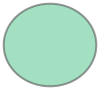

In [32]:
circle_polygon

### Get lat lon of data with landmask - using np for the mask

In [35]:
lat_2d, lon_2d = xr.broadcast(ts_3D_1pm['lat'], ts_3D_1pm['lon'])

In [36]:
mask_land_2d=~np.isnan(ts_3D_1pm[0].values)
mask_land_2d

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]], shape=(300, 300))

In [37]:
land_lons = lon_2d.values[mask_land_2d]
land_lats = lat_2d.values[mask_land_2d]
land_lats

array([-35., -35., -35., ..., -20., -20., -20.], shape=(42052,))

### Create shapely Point series for all points in land (with ts data)

In [38]:
points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(land_lons, land_lats)], crs="EPSG:4326")
points

0              POINT (145 -35)
1        POINT (145.05017 -35)
2        POINT (145.10033 -35)
3         POINT (145.1505 -35)
4        POINT (145.20067 -35)
                 ...          
42047    POINT (148.16054 -20)
42048     POINT (148.2107 -20)
42049    POINT (148.26087 -20)
42050    POINT (148.31104 -20)
42051     POINT (148.3612 -20)
Length: 42052, dtype: geometry

### Identify points in the BNE circle but not in BNE polygon (city)

In [42]:
inside_circle = points.within(circle_polygon)
outside_bne = ~points.within(largest_poly)
# These are the points inside BNE circle - but outside BNE polygon
highlight_mask = inside_circle & outside_bne
pts_in_bne_circle_not_bne_poly = points[highlight_mask]

### Get points inside the BNE city

In [41]:
inside_bne = points.within(largest_poly)
pts_inside_bne = points[inside_bne]

### Plot everything

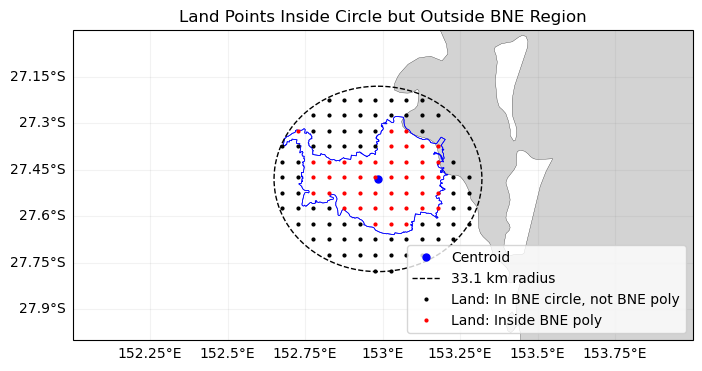

<Figure size 640x480 with 0 Axes>

In [44]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(linewidth=0.2)
ax.add_feature(states_provinces, linewidth=0.1)
ax.add_feature(cf.OCEAN, facecolor='lightgray')
bne_boundary = ShapelyFeature([bne_geometry], ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linestyle='-', linewidth=0.5)
ax.add_feature(bne_boundary)
ax.set_extent([152,154, -28, -27], ccrs.PlateCarree())
gl=ax.gridlines(alpha=0.1, draw_labels=True, color='gray')
gl.top_labels = False
gl.right_labels = False

# Tokyo boundary
ax.add_feature(bne_boundary)

# Centroid + circle
ax.plot(centroid_bne.x, centroid_bne.y, 'bo', markersize=5,
        transform=ccrs.PlateCarree(), label='Centroid')
ax.plot(circle_lons, circle_lats, 'k--', linewidth=1.0, label=f'{radius_km:.1f} km radius')

# Highlighted points outside Tokyo but inside circle
ax.plot(pts_in_bne_circle_not_bne_poly.x, pts_in_bne_circle_not_bne_poly.y, 'k.', markersize=4, 
        label='Land: In BNE circle, not BNE poly')

# Highlighted points inside Tokyo
ax.plot(pts_inside_bne.x, pts_inside_bne.y, 'r.', markersize=4, 
        label='Land: Inside BNE poly')

# Legend and title
ax.legend(loc='lower right')
plt.title("Land Points Inside Circle but Outside BNE Region")
plt.show()

os.chdir('%s' %(plot_path))
plt.savefig('BNE_UM_z10_data_points.png', dpi=300, bbox_inches='tight')

# Start with land temperature

## Checking the difference in temperature
* Between BNE polygon (city)
* BNE circle

In [51]:
tmp = ts_3D_1pm.rio.write_crs("EPSG:4326", inplace=True)
tmp = tmp.rename({'lon':'x', 'lat':'y'})

gdf = gdf.to_crs(tmp.rio.crs)

mask = features.rasterize(
    [(geom, 1) for geom in gdf_bne["geometry"]],
    out_shape=tmp.rio.shape,
    transform=tmp.rio.transform(),
    fill=0,
    dtype='uint8'
)

mask_bne = xr.DataArray(mask, dims=("lat", "lon"), coords={"lat": tmp.y.values, "lon": tmp.x.values})

ts_BNE_poly = ts_3D_1pm.where(mask_bne == 1)   # this is masking 

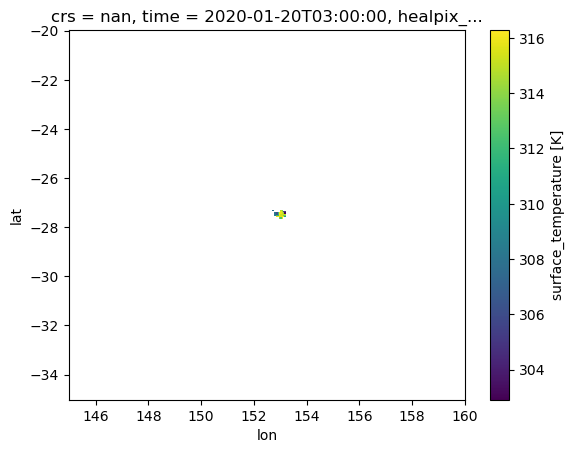

In [52]:
ts_BNE_poly[0].plot()

#### Getting the mask for BNE circle

In [53]:
gdf_cicle = gpd.GeoDataFrame(index=[0], geometry=[circle_polygon], crs=gdf.crs)
gdf_cicle

,geometry
0,"POLYGON ((152.98519 -27.18116, 152.99104 -27.1..."


In [54]:
tmp = ts_3D_1pm.rio.write_crs("EPSG:4326", inplace=True)
tmp = tmp.rename({'lon':'x', 'lat':'y'})

gdf = gdf.to_crs(tmp.rio.crs)

mask = features.rasterize(
    [(geom, 1) for geom in gdf_cicle["geometry"]],
    out_shape=tmp.rio.shape,
    transform=tmp.rio.transform(),
    fill=0,
    dtype='uint8'
)

mask_bne_circle = xr.DataArray(mask, dims=("lat", "lon"), coords={"lat": tmp.y.values, "lon": tmp.x.values})

ts_BNE_circle = ts_3D_1pm.where(mask_bne_circle == 1)   # this is masking 

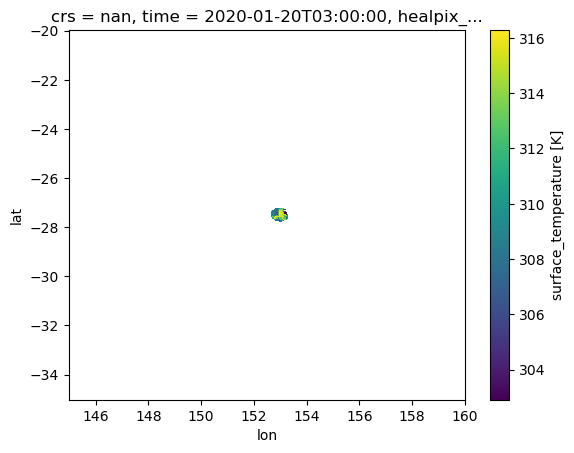

In [55]:
ts_BNE_circle[0].plot()

### Plot timeseries of the two temperatures

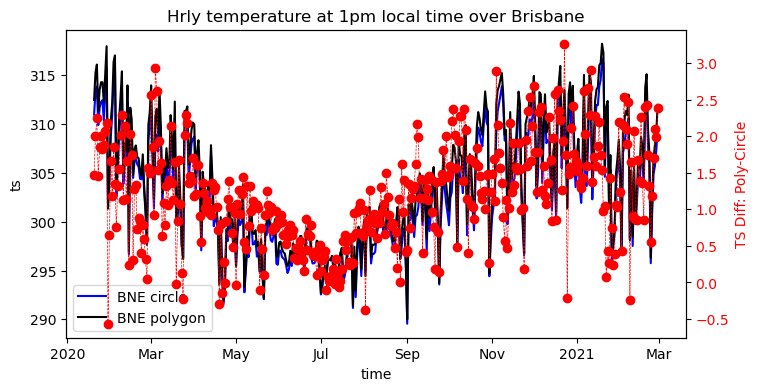

In [64]:
fig, ax1=plt.subplots(figsize=(8, 4))
ts_BNE_circle.mean(dim=('lat','lon')).plot(ax=ax1, color='b', label='BNE circle')
ts_BNE_poly.mean(dim=('lat','lon')).plot(ax=ax1, color='k', label='BNE polygon')
plt.title('')
plt.legend()

ax2=ax1.twinx()
(ts_BNE_poly.mean(dim=('lat','lon'))-ts_BNE_circle.mean(dim=('lat','lon'))).plot(ax=ax2, linewidth=0.5, linestyle='--',
                                                                                 marker='o',color='r', label='Poly-Circ')
ax2.set_ylabel('TS Diff: Poly-Circle', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title("Hrly temperature at 1pm local time over Brisbane")

os.chdir('%s' %(plot_path))
plt.savefig('TS_BNE_poly_circ.png', dpi=300, bbox_inches='tight')

### Define a buffer zone
* Assuming that the buffer zone is a factor of the urban radius

In [66]:
rat_buff=3
rad_buff = rat_buff * radius_km
rad_buff

99.41356288458697

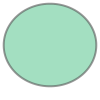

In [67]:
buff_circle_lons, buff_circle_lats = create_circle(center_lat, center_lon, rad_buff)
buff_circle_polygon = Polygon(zip(buff_circle_lons, buff_circle_lats))  # For masking
buff_circle_polygon

### Masking and temperature in the buffer region
* Ensure that the masking for buffer removes the city poly in between

In [69]:
gdf_buff = gpd.GeoDataFrame(index=[0], geometry=[buff_circle_polygon], crs=gdf.crs)

tmp = ts_3D_1pm.rio.write_crs("EPSG:4326", inplace=True)
tmp = tmp.rename({'lon':'x', 'lat':'y'})

gdf = gdf.to_crs(tmp.rio.crs)

mask = features.rasterize(
    [(geom, 1) for geom in gdf_buff["geometry"]],
    out_shape=tmp.rio.shape,
    transform=tmp.rio.transform(),
    fill=0,
    dtype='uint8'
)

mask_buff_circle = xr.DataArray(mask, dims=("lat", "lon"), coords={"lat": tmp.y.values, "lon": tmp.x.values})

#### Notice that BNE city poly is cropped out of buffer circle

In [72]:
ts_buff = ts_3D_1pm.where((mask_buff_circle == 1) & (mask_bne == 0))   # this is masking 

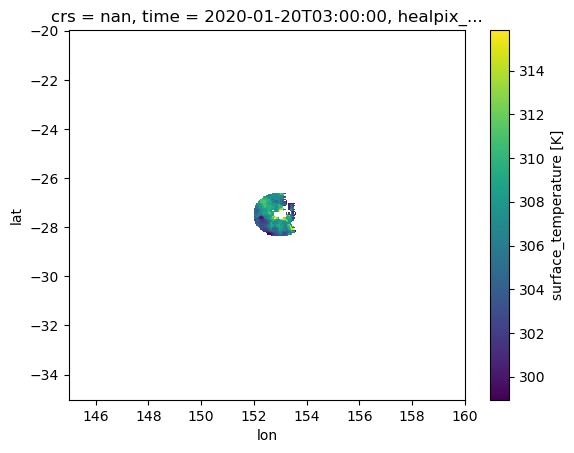

In [73]:
ts_buff[0].plot()

### Timeseries of BNE poly and buffer + UHI

In [ ]:
fig=plt.figure(figsize=(12, 8))

ax1=plt.subplot(211)
ax1.grid(alpha=0.3)
ts_BNE_poly.mean(dim=('lat','lon')).plot(ax=ax1, color='blue', label='BNE polygon')
ts_buff.mean(dim=('lat','lon')).plot(ax=ax1, color='grey', label='Buffer (r=%.0f km)' %(rad_buff))
plt.title("Hrly temperatures at 1pm local time around Brisbane")
plt.ylabel('TS (K)')
plt.xlabel('')
plt.legend()

ax2=plt.subplot(212)
ax2.grid(alpha=0.3)
(ts_BNE_poly.mean(dim=('lat','lon'))-ts_buff.mean(dim=('lat','lon'))).plot(ax=ax2, linewidth=0.5, linestyle='--',
                                                                                 marker='o',color='r', label='UHI')
plt.ylabel('TS UHI: Poly - Buff (%s x city_rad)' %(rat_buff), color='r')
plt.tick_params(axis='y', labelcolor='r')
plt.title("Urban Heat Island effect on TS ")

os.chdir('%s' %(plot_path))
plt.savefig('TS_BNE_UHI.png', dpi=200, bbox_inches='tight')